In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

class PetFacesDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self, num_classes=35):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, H/2, W/2]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, H/4, W/4]
        x = self.pool(F.relu(self.conv3(x)))  # [B, 128, H/8, W/8]
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [ ]:
class BinaryCNNClassifier(nn.Module):
    def __init__(self, num_filters=32, kernel_size=3, hidden_dim=128, dropout_rate=0.5):
        super(BinaryCNNClassifier, self).__init__()
        self.num_filters = num_filters

        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=kernel_size, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, kernel_size=kernel_size, padding=1)
        self.conv3 = nn.Conv2d(num_filters * 2, num_filters * 4, kernel_size=kernel_size, padding=1)

        self.fc1 = nn.Linear(num_filters * 4 * 8 * 8, hidden_dim)  # Теперь num_filters доступен через self.
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x)).squeeze(1)
        return x


In [ ]:
!wget -q http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar -xzf petfaces.tar.gz
!rm petfaces.tar.gz



✅ Архив petfaces.tar.gz загружен и распакован


In [ ]:
from sklearn.preprocessing import LabelEncoder

image_paths = []
labels = []

for root, dirs, files in os.walk("petfaces"):
    for file in files:
        if file.endswith(".jpg"):
            path = os.path.join(root, file)
            label = root.split("/")[-1]
            image_paths.append(path)
            labels.append(label)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

binary_labels = [0 if "cat" in l else 1 for l in labels]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(image_paths, encoded_labels))

import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


train_dataset = PetFacesDataset([image_paths[i] for i in train_idx],
                                [encoded_labels[i] for i in train_idx], transform)
test_dataset = PetFacesDataset([image_paths[i] for i in test_idx],
                               [encoded_labels[i] for i in test_idx], transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model = model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            if isinstance(criterion, nn.BCELoss):
                labels = labels.float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

    return model

In [ ]:
def evaluate_model(model, test_loader, num_classes=35, is_binary=False, device='cpu'):
    model.eval()
    model.to(device)
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            if is_binary:
                labels = labels.float()

            outputs = model(inputs)

            if is_binary:
                preds = (outputs > 0.5).float()
            else:
                _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')
    return accuracy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_multi = CNNClassifier(num_classes=35)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_multi.parameters(), lr=0.001)

model_multi = train_model(model_multi, train_loader, test_loader, criterion, optimizer, num_epochs=15, device=device)
evaluate_model(model_multi, test_loader, num_classes=35, is_binary=False, device=device)


Epoch [1/15] - Loss: 3.4046
Epoch [2/15] - Loss: 2.9694
Epoch [3/15] - Loss: 2.4678
Epoch [4/15] - Loss: 2.0357
Epoch [5/15] - Loss: 1.7540
Epoch [6/15] - Loss: 1.5191
Epoch [7/15] - Loss: 1.3241
Epoch [8/15] - Loss: 1.1529
Epoch [9/15] - Loss: 0.9964
Epoch [10/15] - Loss: 0.8322
Epoch [11/15] - Loss: 0.7150
Epoch [12/15] - Loss: 0.6146
Epoch [13/15] - Loss: 0.5846
Epoch [14/15] - Loss: 0.4493
Epoch [15/15] - Loss: 0.4134
Accuracy: 0.5365


0.536547433903577

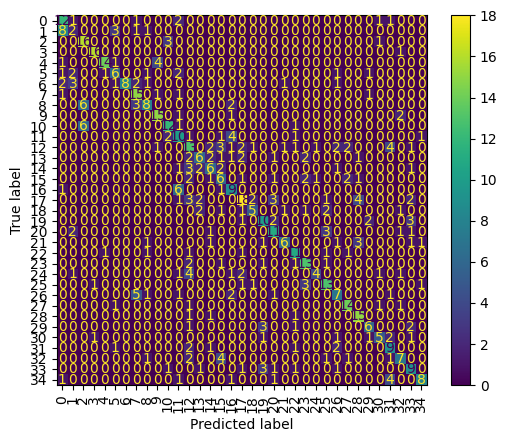

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []
model_multi.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model_multi(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical')


In [ ]:
def top_k_accuracy(model, dataloader, k=3):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            topk = torch.topk(outputs, k=k, dim=1).indices
            for i in range(labels.size(0)):
                if labels[i] in topk[i]:
                    correct += 1
            total += labels.size(0)
    return correct / total

top3_acc = top_k_accuracy(model_multi, test_loader, k=3)
print(f"Top-3 Accuracy: {top3_acc:.4f}")


Top-3 Accuracy: 0.7776


In [ ]:
train_dataset_binary = PetFacesDataset([image_paths[i] for i in train_idx],
                                       [binary_labels[i] for i in train_idx], transform)
test_dataset_binary = PetFacesDataset([image_paths[i] for i in test_idx],
                                      [binary_labels[i] for i in test_idx], transform)

train_loader_bin = DataLoader(train_dataset_binary, batch_size=64, shuffle=True)
test_loader_bin = DataLoader(test_dataset_binary, batch_size=64)


In [ ]:
model_bin = BinaryCNNClassifier()
criterion_bin = nn.BCELoss()
optimizer_bin = torch.optim.Adam(model_bin.parameters(), lr=0.001)

model_bin = train_model(model_bin, train_loader_bin, test_loader_bin, criterion_bin, optimizer_bin, num_epochs=10, device=device)
evaluate_model(model_bin, test_loader_bin, is_binary=True, device=device)


Epoch [1/10] - Loss: 0.5942
Epoch [2/10] - Loss: 0.3752
Epoch [3/10] - Loss: 0.2678
Epoch [4/10] - Loss: 0.2069
Epoch [5/10] - Loss: 0.1734
Epoch [6/10] - Loss: 0.1444
Epoch [7/10] - Loss: 0.1222
Epoch [8/10] - Loss: 0.0963
Epoch [9/10] - Loss: 0.0996
Epoch [10/10] - Loss: 0.0713
Accuracy: 0.9347


0.9346811819595645

Оптимизация параметров